In [1]:
##notebook modified from rguo123: Richard Guo

import mixed
import time
import pandas as pd
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### UF CODE
'''
Primary Author: Will LeVine
Email: levinewill@icloud.com
'''
#Model
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Infrastructure
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import NotFittedError

#Data Handling
from sklearn.utils.validation import (
    check_X_y,
    check_array,
    NotFittedError,
)
from sklearn.utils.multiclass import check_classification_targets

#Utils
from joblib import Parallel, delayed
import numpy as np

def _finite_sample_correction(posteriors, num_points_in_partition, num_classes):
    '''
    encourage posteriors to approach uniform when there is low data
    '''
    correction_constant = 1 / (num_classes * num_points_in_partition)

    zero_posterior_idxs = np.where(posteriors == 0)[0]
    posteriors[zero_posterior_idxs] = correction_constant
    
    posteriors /= sum(posteriors)
    
    return posteriors

class UncertaintyForest(BaseEstimator, ClassifierMixin):
    '''
    based off of https://arxiv.org/pdf/1907.00325.pdf
    '''
    def __init__(
        self,
        max_depth=30,
        min_samples_leaf=1,
        max_samples = 0.63,
        max_features_tree = "auto",
        n_estimators=100,
        bootstrap=False,
        parallel=True,
        n_jobs = None):

        #Tree parameters.
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features_tree = max_features_tree

        #Bag parameters
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.max_samples = max_samples

        #Model parameters.
        self.parallel = parallel
        if self.parallel and n_jobs == None:
            self.n_jobs = self.n_estimators
        else:
            self.n_jobs = n_jobs
        self.fitted = False

    def _check_fit(self):
        '''
        raise a NotFittedError if the model isn't fit
        '''
        if not self.fitted:
                msg = (
                        "This %(name)s instance is not fitted yet. Call 'fit' with "
                        "appropriate arguments before using this estimator."
                )
                raise NotFittedError(msg % {"name": type(self).__name__})

    def transform(self, X):
        '''
        get the estimated posteriors across trees
        '''
        X = check_array(X)
                
        def worker(tree_idx, tree):
            #get the nodes of X
            # Drop each estimation example down the tree, and record its 'y' value.
            return tree.apply(X)
            

        if self.parallel:
            return np.array(
                    Parallel(n_jobs=self.n_jobs)(
                            delayed(worker)(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)
                    )
            )         
        else:
            return np.array(
                    [worker(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)]
                    )
        
    def get_transformer(self):
        return lambda X : self.transform(X)
        
    def vote(self, nodes_across_trees):
        return self.voter.predict(nodes_across_trees)
        
    def get_voter(self):
        return self.voter
        
                        
    def fit(self, X, y):

        #format X and y
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        
        #define the ensemble
        self.ensemble = BaggingClassifier(
            DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features_tree
            ),
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,
            bootstrap=self.bootstrap,
            n_jobs = self.n_jobs
        )
        
        #fit the ensemble
        self.ensemble.fit(X, y)
        
        class Voter(BaseEstimator):
            def __init__(self, estimators_samples_, classes, parallel, n_jobs):
                self.n_estimators = len(estimators_samples_)
                self.classes_ = classes
                self.parallel = parallel
                self.estimators_samples_ = estimators_samples_
                self.n_jobs = n_jobs
            
            def fit(self, nodes_across_trees, y, fitting = False):
                self.tree_idx_to_node_ids_to_posterior_map = {}

                def worker(tree_idx):
                    nodes = nodes_across_trees[tree_idx]
                    oob_samples = np.delete(range(len(nodes)), self.estimators_samples_[tree_idx])
                    cal_nodes = nodes[oob_samples] if fitting else nodes
                    y_cal = y[oob_samples] if fitting else y                    
                    
                    #create a map from the unique node ids to their classwise posteriors
                    node_ids_to_posterior_map = {}

                    #fill in the posteriors 
                    for node_id in np.unique(cal_nodes):
                        cal_idxs_of_node_id = np.where(cal_nodes == node_id)[0]
                        cal_ys_of_node = y_cal[cal_idxs_of_node_id]
                        class_counts = [len(np.where(cal_ys_of_node == y)[0]) for y in np.unique(y) ]
                        posteriors = np.nan_to_num(np.array(class_counts) / np.sum(class_counts))

                        #finite sample correction
                        posteriors_corrected = _finite_sample_correction(posteriors, len(cal_idxs_of_node_id), len(self.classes_))
                        node_ids_to_posterior_map[node_id] = posteriors_corrected

                    #add the node_ids_to_posterior_map to the overall tree_idx map 
                    self.tree_idx_to_node_ids_to_posterior_map[tree_idx] = node_ids_to_posterior_map
                    
                for tree_idx in range(self.n_estimators):
                        worker(tree_idx)
                return self
                        
                        
            def predict_proba(self, nodes_across_trees):
                def worker(tree_idx):
                    #get the node_ids_to_posterior_map for this tree
                    node_ids_to_posterior_map = self.tree_idx_to_node_ids_to_posterior_map[tree_idx]

                    #get the nodes of X
                    nodes = nodes_across_trees[tree_idx]

                    posteriors = []
                    node_ids = node_ids_to_posterior_map.keys()

                    #loop over nodes of X
                    for node in nodes:
                        #if we've seen this node before, simply get the posterior
                        if node in node_ids:
                            posteriors.append(node_ids_to_posterior_map[node])
                        #if we haven't seen this node before, simply use the uniform posterior 
                        else:
                            posteriors.append(np.ones((len(np.unique(self.classes_)))) / len(self.classes_))
                    return posteriors

                if self.parallel:
                    return np.mean(
                            Parallel(n_jobs=self.n_jobs)(
                                    delayed(worker)(tree_idx) for tree_idx in range(self.n_estimators)
                            ), axis = 0
                    )

                else:
                    return np.mean(
                            [worker(tree_idx) for tree_idx in range(self.n_estimators)], axis = 0)
                
        #get the nodes of the calibration set
        nodes_across_trees = self.transform(X) 
        self.voter = Voter(estimators_samples_ = self.ensemble.estimators_samples_, classes = self.classes_, parallel = self.parallel, n_jobs = self.n_jobs)
        self.voter.fit(nodes_across_trees, y, fitting = True)
        self.fitted = True

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=-1)]

    def predict_proba(self, X):
        return self.voter.predict_proba(self.transform(X))

In [3]:
def generate_big_data(n_samples=10000, n_features=100):
    X = np.random.rand(n_samples, n_features)
    y = np.random.binomial(1, .5, n_samples)
    return X, np.ravel(y)

In [4]:
# n_samples = 1000 #10000000 
# n_features = 10 #50000

In [5]:
# X, y = generate_big_data(n_samples=n_samples, n_features=n_features)

In [6]:
# model = UncertaintyForest(n_estimators = 10, parallel=False) # for samples timing
model = UncertaintyForest(n_estimators = 300, parallel=False) # for features timing - 300 trees


In [7]:
# irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 10), 
#                                      method='isotonic', 
#                                      cv = 5) #for samples timing
irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5) # for features timing - 300 trees

In [8]:
uf_elapsed_varysamples = []
uf_elapsed_varyfeatures = []
irf_elapsed_varysamples = []
irf_elapsed_varyfeatures = []
ksg_elapsed_varysamples = []
ksg_elapsed_varyfeatures = []

In [9]:
sample_range = range(100,1000000, 50000)
feature_range = range(1, 5000, 500)

In [10]:
# for i in sample_range: #(1,1000000,100000)
#     X, y = generate_big_data(n_samples=i, n_features=10)

#     start = time.time()
#     mixed.KSG(X, y)
#     end = time.time()
#     ksg_elapsed = end - start
#     print(ksg_elapsed)
#     logging.basicConfig(filename='logs.log', level=logging.INFO)
#     logging.info('ksg samples: {}, {}'.format(i,ksg_elapsed))
#     ksg_elapsed_varysamples.append(ksg_elapsed)

#     start = time.time()
#     model.fit(X, y)
#     end = time.time()
#     uf_elapsed = end - start
#     print(uf_elapsed)
#     logging.basicConfig(filename='logs.log', level=logging.INFO)
#     logging.info('uf samples: {}, {}'.format(i,uf_elapsed))
#     uf_elapsed_varysamples.append(uf_elapsed)

#     start = time.time()
#     irf.fit(X, y) 
#     end = time.time()
#     irf_elapsed = end - start
#     print(irf_elapsed)
#     logging.basicConfig(filename='logs.log', level=logging.INFO)
#     logging.info('irf samples: {}, {}'.format(i,irf_elapsed))
#     irf_elapsed_varysamples.append(irf_elapsed)



In [11]:
for i in feature_range:
    X, y = generate_big_data(n_samples=10000, n_features=i) #100000

    start = time.time()
    mixed.KSG(X, y)
    end = time.time()
    ksg_elapsed = end - start
    print(ksg_elapsed)
    logging.basicConfig(filename='logs.log', level=logging.INFO)
    logging.info('ksg features: {}, {}'.format(i,ksg_elapsed))
    ksg_elapsed_varyfeatures.append(ksg_elapsed)

    start = time.time()
    model.fit(X, y)
    end = time.time()
    uf_elapsed = end - start
    print(uf_elapsed)
    logging.basicConfig(filename='logs.log', level=logging.INFO)
    logging.info('uf features: {}, {}'.format(i,uf_elapsed))
    uf_elapsed_varyfeatures.append(uf_elapsed)

    start = time.time()
    irf.fit(X, y) 
    end = time.time()
    irf_elapsed = end - start
    print(irf_elapsed)
    logging.basicConfig(filename='logs.log', level=logging.INFO)
    logging.info('irf features: {}, {}'.format(i,irf_elapsed))
    irf_elapsed_varyfeatures.append(irf_elapsed)


3.072941303253174
34.565152645111084
25.291165351867676
312.72216415405273
104.4485433101654
197.65098929405212
611.6700806617737
134.09013414382935
278.5357325077057
909.6007866859436
166.82206559181213
342.4424731731415
1211.1732413768768
195.40964531898499
396.65995359420776
1513.752043247223
220.8855082988739
450.6983871459961
1817.0580561161041
240.33981895446777
487.5677330493927
2121.290022611618
272.4932425022125
546.5235104560852
2430.997558116913
292.08322405815125
577.1769924163818
2720.9187977313995
308.13527727127075
613.2127630710602


In [12]:
# start = time.time()
# mixed.KSG(X, y)
# end = time.time()
# ksg_elapsed = end - start
# print(ksg_elapsed)

In [13]:
# Stitch it together in a dataframe.
# runtime_dict = {
#     "n_samples": n_samples,
#     "n_features": n_features,
#     "uf": uf_elapsed,
#     "ksg": ksg_elapsed
# }

# table = pd.DataFrame(runtime_dict, index=["values"])
# table.to_csv("runtime_table.csv", index = False)
# print(table)

In [14]:
with open("logs.log") as log:
            print(log.read())

INFO:root:ksg samples: 100, 0.022138118743896484
INFO:root:uf samples: 100, 0.02369379997253418
INFO:root:irf samples: 100, 0.06048989295959473
INFO:root:ksg samples: 50100, 130.5437409877777
INFO:root:uf samples: 50100, 28.24382781982422
INFO:root:irf samples: 50100, 9.068161010742188
INFO:root:ksg samples: 100100, 915.2642238140106
INFO:root:uf samples: 100100, 74.79136347770691
INFO:root:irf samples: 100100, 23.289907693862915
INFO:root:ksg samples: 150100, 795.6373760700226
INFO:root:uf samples: 150100, 129.33696842193604
INFO:root:irf samples: 150100, 41.30687499046326
INFO:root:ksg samples: 200100, 25801.769067287445
INFO:root:uf samples: 200100, 188.93815875053406
INFO:root:irf samples: 200100, 60.10387182235718
INFO:root:ksg samples: 250100, 1486.4204728603363
INFO:root:uf samples: 250100, 322.82367753982544
INFO:root:irf samples: 250100, 75.78276920318604
INFO:root:ksg features: 1, 3.072941303253174
INFO:root:uf features: 1, 34.565152645111084
INFO:root:irf features: 1, 25.291

In [15]:
print(uf_elapsed_varysamples)
print(ksg_elapsed_varysamples)
print(irf_elapsed_varysamples)


[]
[]
[]


In [16]:
print(uf_elapsed_varyfeatures)
print(ksg_elapsed_varyfeatures)
print(irf_elapsed_varyfeatures)

[34.565152645111084, 104.4485433101654, 134.09013414382935, 166.82206559181213, 195.40964531898499, 220.8855082988739, 240.33981895446777, 272.4932425022125, 292.08322405815125, 308.13527727127075]
[3.072941303253174, 312.72216415405273, 611.6700806617737, 909.6007866859436, 1211.1732413768768, 1513.752043247223, 1817.0580561161041, 2121.290022611618, 2430.997558116913, 2720.9187977313995]
[25.291165351867676, 197.65098929405212, 278.5357325077057, 342.4424731731415, 396.65995359420776, 450.6983871459961, 487.5677330493927, 546.5235104560852, 577.1769924163818, 613.2127630710602]


In [17]:
def plot_tvsamples(ax):
    linewidth = 8
    opacity = 1
    ax.set_title('Time vs. Samples')

    if len(sample_range) == len(uf_elapsed_varysamples):
        ax.plot(sample_range, uf_elapsed_varysamples, 
                label = 'UF',
                linewidth = linewidth, 
                color = '#F41711', 
                alpha = opacity)
    if len(sample_range) == len(ksg_elapsed_varysamples):
        ax.plot(sample_range, ksg_elapsed_varysamples, 
                label = 'KSG',
                linewidth = linewidth, 
                color = '#1b9e77', 
                alpha = opacity)

    if len(sample_range) == len(irf_elapsed_varysamples):
        ax.plot(sample_range, irf_elapsed_varysamples, 
                label = 'IRF',
                linewidth = linewidth, 
                color = '#fdae61', 
                alpha = opacity)      

def plot_tvfeatures(ax):
    linewidth = 8
    opacity = 1
    ax.set_title('Time vs. Features')
    if len(feature_range) == len(uf_elapsed_varyfeatures):
        ax.plot(feature_range, uf_elapsed_varyfeatures, 
                label = 'UF',
                linewidth = linewidth, 
                color = '#F41711', 
                alpha = opacity)
    if len(feature_range) == len(ksg_elapsed_varyfeatures):
        ax.plot(feature_range, ksg_elapsed_varyfeatures, 
                label = 'KSG',
                linewidth = linewidth, 
                color = '#1b9e77', 
                alpha = opacity)

    if len(feature_range) == len(irf_elapsed_varyfeatures):
        ax.plot(feature_range, irf_elapsed_varyfeatures, 
                label = 'IRF',
                linewidth = linewidth, 
                color = '#fdae61', 
                alpha = opacity)    



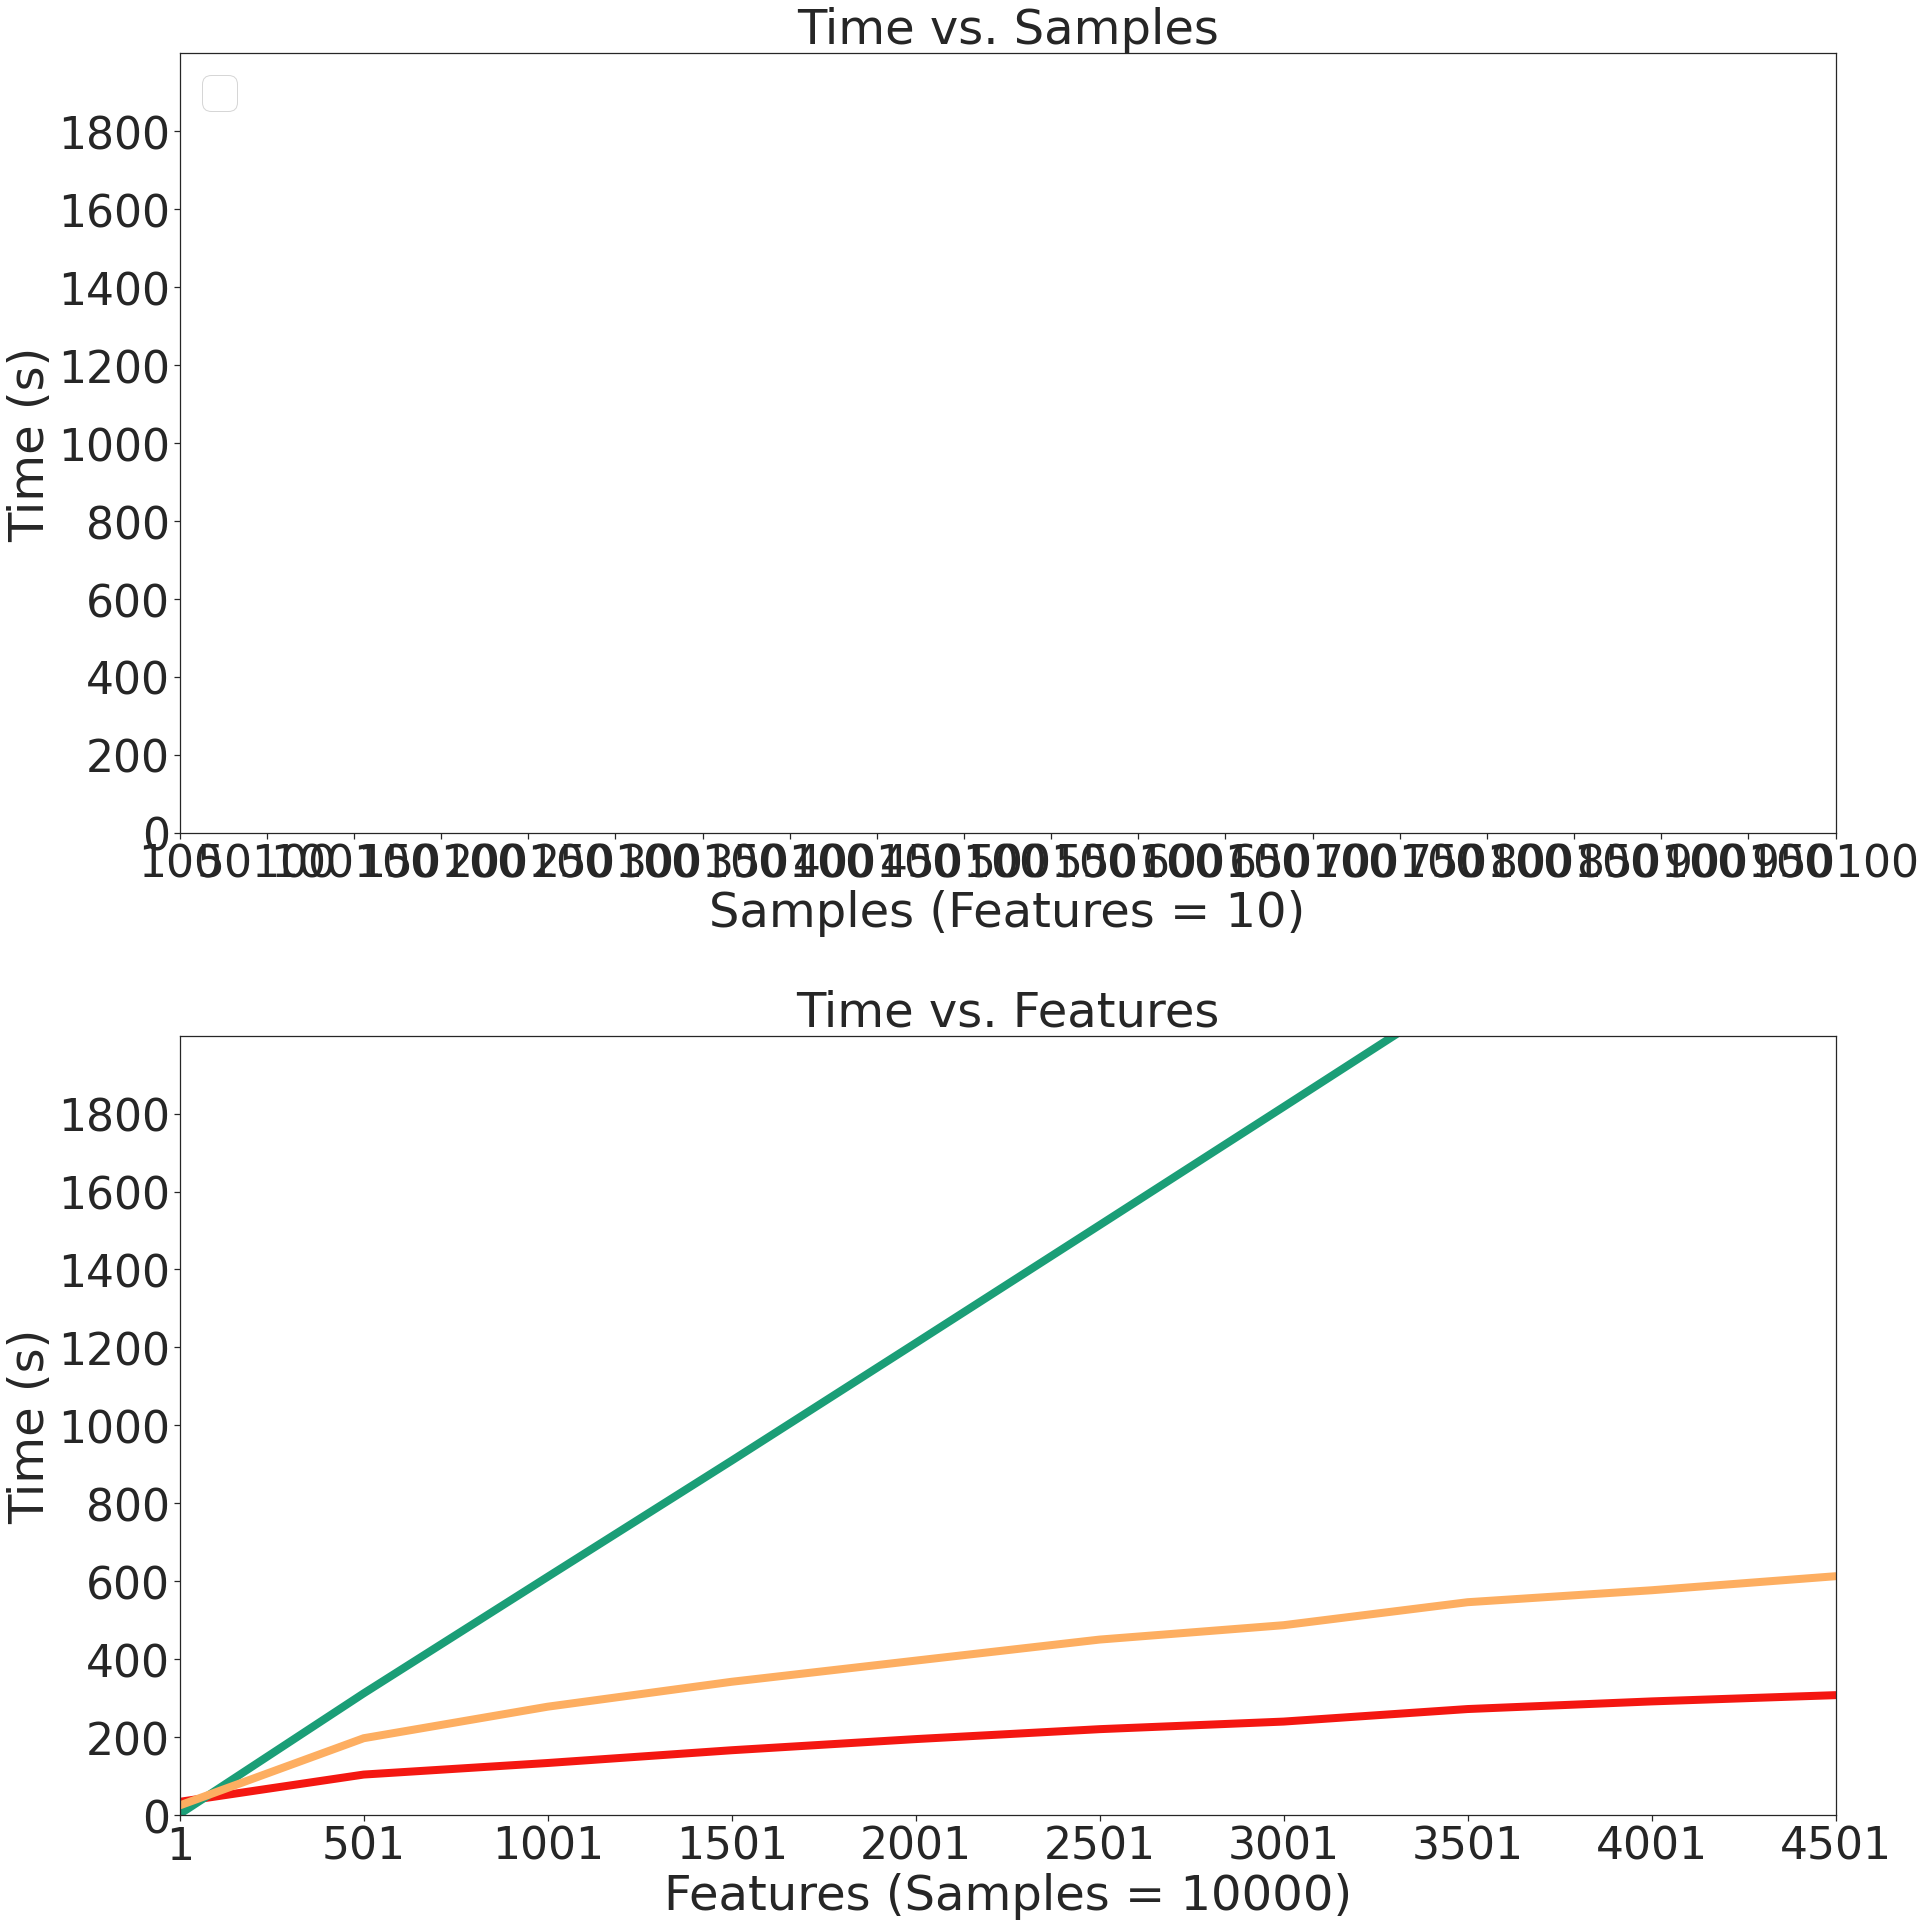

In [18]:
def plot_timefigs():
    sns.set(font_scale = 4)
    sns.set_style("ticks")
    plt.rcParams['figure.figsize'] = [28, 28]
    fig, axes = plt.subplots(2, 1)
    axes[0].set_ylim(-0.05, 2000.0)
    axes[1].set_ylim(-0.05, 2000.0)
    
    axes[0].set_xlim(sample_range[0], sample_range[1])
    axes[1].set_xlim(feature_range[0],feature_range[1])
    axes[0].xaxis.set_ticks(sample_range)
    axes[1].xaxis.set_ticks(feature_range)

    axes[0].yaxis.set_ticks(np.arange(0.0, 2000.0, 200.0))
    axes[1].yaxis.set_ticks(np.arange(0.0, 2000.0, 200.0))

    plot_tvsamples(axes[0])
    plot_tvfeatures(axes[1])

    axes[0].set_ylabel("Time (s)")
    axes[1].set_ylabel("Time (s)")
    axes[0].set_xlabel("Samples (Features = 10)")
    axes[1].set_xlabel("Features (Samples = 10000)")

    axes[0].legend(loc = "upper left")

    fig.tight_layout()
    plt.savefig("fig_timing.pdf")
    plt.show()
    
plot_timefigs()
